# Example-03: Implicit midpoint integrator

In [1]:
# In this example implicit midpoint integrator usage is illustrated
# Integration step is constructed from a given hamiltonian h(q, p, t, *args)
# The resulting integration step signature is (qp, dt, t, *args)
# Integration step can be used with Yoshida composition and is JAX composable

In [2]:
# Import

import jax
from jax import jit
from jax import vmap

# Function iterations

from sympint import nest
from sympint import nest_list

from sympint import fold
from sympint import fold_list

# Yoshida composition

from sympint import sequence

# Implicit midpoint integrator

from sympint import midpoint

# Plotting

from matplotlib import pyplot as plt

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Construct Yoshida composition step (multi-map integrator)

# H = H1 + H2
# H1 = 1/2 q**2 + 1/3 q**3 -> [q, p] -> [q, p - t*q - t*q**2]
# H2 = 1/2 p**2            -> [q, p] -> [q + t*q, p]

# Set mappings for sovable parts

def fn(x, t):
    q, p = x
    return jax.numpy.stack([q, p - t*(q + q**2)])

def gn(x, t):
    q, p = x
    return jax.numpy.stack([q + t*p, p])

# Generate Yoshida sequence

fs = sequence(0, 2, [fn, gn], merge=True)
print(len(fs))

# Generate folded step (sequence composition)

integrator = fold(fs)

# Set parameters

dt = jax.numpy.array(0.01)
x = jax.numpy.array([0.1, -0.05])

# Compile several integration steps

step = jit(nest(10, integrator))
xa = step(x, dt)
xa

19


Array([ 0.09446052, -0.06067929], dtype=float64)

In [6]:
%%timeit

step(x, dt)

27.3 µs ± 905 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
# Construct Yoshida composition step (implicit midpoint)

# Define hamiltonian function

def h(q, p, t, *args):
    return jax.numpy.sum(1/2*(q**2 + p**2) + 1/3*q**3)

# Define implicit step

integrator = midpoint(h, ns=1)

# Generate Yoshida sequence

fs = sequence(0, 2, [integrator], merge=False)
print(len(fs))

# Generate folded step (sequence composition)

integrator = fold(fs)

# Set parameters

dt = jax.numpy.array(0.01)
t = jax.numpy.array(0.0)
x = jax.numpy.array([0.1, -0.05])

# Compile several steps

step = jit(nest(10, integrator))
xb = step(x, dt, t)
xb

9


Array([ 0.09446052, -0.06067929], dtype=float64)

In [8]:
%%timeit

# Timing

step(x, dt, t)

262 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
# Compare

jax.numpy.isclose(jax.numpy.linalg.norm(xa - xb), 0.0)

Array(True, dtype=bool)

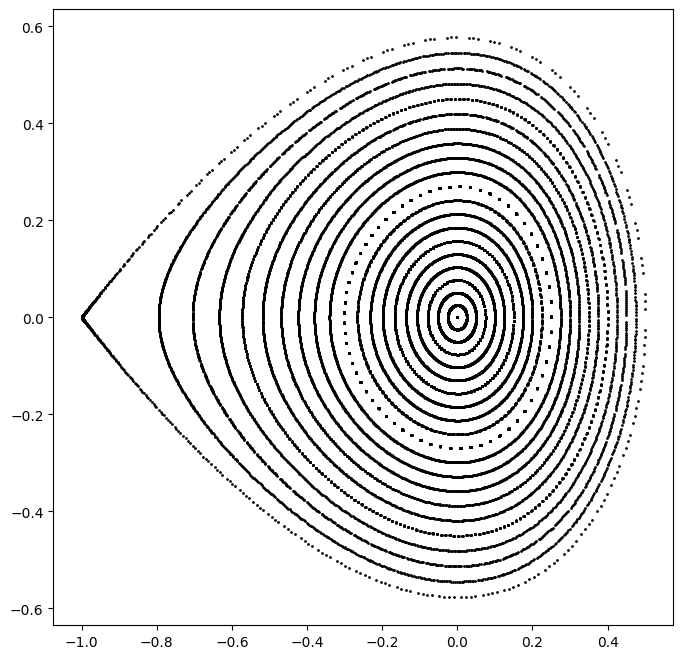

In [10]:
# Plot several phase space trajectories

# Define single orbit generator 

orbit = jit(nest_list(2**10, step))
orbit(x, dt, t)

# Generate several orbits

qs = jax.numpy.linspace(0.0, 0.5, 21)
ps = jax.numpy.zeros_like(qs)
xs = jax.numpy.stack([qs, ps]).T

trajectories = vmap(orbit, (0, None, None))(xs, dt, t)

# Plot orbits

plt.figure(figsize=(8, 8))
for trajectory in trajectories:
    plt.scatter(*trajectory.T, color='black', marker='o', s=1)
plt.show()

In [11]:
# Implicit step is differentiable with respect to initial condition and parameters

jax.jacrev(integrator)(x, dt, t)

Array([[ 0.99994002,  0.0099998 ],
       [-0.01199472,  0.99994003]], dtype=float64)

In [12]:
# Batched evaluation with vectorized map

In [13]:
%%time

jax.numpy.stack([orbit(x, dt, t) for x in xs]).shape

CPU times: user 5.64 s, sys: 9.39 ms, total: 5.65 s
Wall time: 5.55 s


(21, 1024, 2)

In [14]:
%%time

vmap(orbit, (0, None, None))(xs, dt, t).shape

CPU times: user 1.08 ms, sys: 11 µs, total: 1.09 ms
Wall time: 933 µs


(21, 1024, 2)

In [15]:
# Compile
# Note, changing batch size will trigger a recompile

fj = jit(vmap(orbit, (0, None, None)))
fj(xs, dt, t).shape

(21, 1024, 2)

In [16]:
%%time

fj(xs, dt, t).shape

CPU times: user 1.36 ms, sys: 0 ns, total: 1.36 ms
Wall time: 317 µs


(21, 1024, 2)